In [45]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import pandas as pd

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

from seaborn import heatmap
import seaborn as sns
from scipy.sparse import hstack

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lancesinson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
def compute_bow(documents, max_features):
    """
    Computes the bag-of-words matrix for the given documents.

    Parameters:
    - documents: List of text documents.
    - max_features: Maximum number of features (vocabulary size).

    Returns:
    - bow_matrix: Sparse matrix of shape (n_samples, n_features).
    """

    vectorizer = CountVectorizer(max_features=max_features)
    bow_matrix = vectorizer.fit_transform(documents)
    return bow_matrix

In [49]:
def compute_tfidf(documents, max_features):
    """
    Computes the tfidf matrix for the given documents.

    Parameters:
    - documents: List of text documents.
    - max_features: Maximum number of features to use.

    Returns:
    - tfidf_matrix: Sparse matrix of shape (n_samples, n_features).
    """
   
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()  # Extract feature names
    return tfidf_matrix, feature_names

In [51]:
def apply_lsa(tfidf_matrix, n_components):
    """
    Applies LSA (using TruncatedSVD) to the tfidf matrix.

    Parameters:
    - tfidf_matrix: Sparse matrix from tfidf vectorization.
    - n_components: Number of components to keep.

    Returns:
    - lsa_matrix: Dense matrix with reduced dimensions.
    """
 
    vectorizer = TruncatedSVD(n_components=n_components)
    lsa_matrix = vectorizer.fit_transform(tfidf_matrix)
    return lsa_matrix

In [53]:
def create_documents(df):
  documents = df['review'].tolist()
  return documents

In [55]:
def create_labels(df):
  labels = df['voted_up'].tolist()
  return labels

In [57]:
def compute_vader_sentiment_scores(documents):
    analyzer = SentimentIntensityAnalyzer()
    scores = []

    for doc in documents:
        sentiment = analyzer.polarity_scores(doc)
        scores.append(sentiment)  # This is a dict with 'neg', 'neu', 'pos', 'compound'

    return pd.DataFrame(scores)


In [59]:
max_features = 1000

In [61]:
df = pd.read_csv('cleaned_data.csv')
documents = create_documents(df)

#vader_scores_df = compute_vader_sentiment_scores(documents) #create the scores (and for now do literally nothing with them)
#df = pd.concat([df, vader_scores_df], axis=1)

labels = create_labels(df)

In [96]:
bow_matrix = compute_bow(documents, 1000)
print("Bag of words matrix:")
print(bow_matrix)

tfidf_matrix, feature_names = compute_tfidf(documents, 1000)
print("TF-IDF matrix:")
print(tfidf_matrix)

lsa_matrix = apply_lsa(tfidf_matrix, 100)
print("LSA matrix:")
print(lsa_matrix)

Bag of words matrix:
  (1, 659)	1
  (1, 644)	1
  (1, 353)	1
  (1, 613)	1
  (1, 781)	1
  (2, 659)	1
  (2, 103)	1
  (2, 974)	1
  (2, 566)	1
  (2, 51)	1
  (3, 353)	1
  (3, 974)	1
  (3, 51)	3
  (3, 575)	1
  (3, 343)	1
  (3, 968)	1
  (3, 658)	1
  (3, 829)	1
  (3, 737)	1
  (3, 439)	1
  (3, 676)	1
  (3, 728)	1
  (3, 609)	1
  (3, 858)	1
  (3, 458)	1
  :	:
  (193173, 797)	2
  (193173, 321)	1
  (193173, 463)	1
  (193173, 218)	1
  (193173, 827)	1
  (193173, 304)	1
  (193173, 227)	1
  (193173, 311)	1
  (193173, 258)	1
  (193173, 241)	2
  (193173, 186)	1
  (193173, 573)	1
  (193173, 976)	1
  (193173, 717)	1
  (193173, 699)	1
  (193173, 760)	2
  (193173, 733)	1
  (193173, 223)	1
  (193173, 634)	1
  (193173, 745)	1
  (193173, 456)	1
  (193173, 457)	1
  (193173, 257)	2
  (193173, 540)	1
  (193173, 908)	1
TF-IDF matrix:
  (1, 659)	0.3927349272193502
  (1, 644)	0.5173331748388696
  (1, 353)	0.19785073479048174
  (1, 613)	0.5866189284370509
  (1, 781)	0.4414283437834276
  (2, 659)	0.42487761072250263
  (

In [63]:
from sklearn.preprocessing import StandardScaler

# Feature engineering

df['review_length'] = df['review'].astype(str).apply(len)
df['reviews_per_game'] = df['author_num_reviews'] / (df['author_num_games_owned'] + 1)

df['review_timestamp'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['review_day_of_week'] = df['review_timestamp'].dt.dayofweek
df['review_hour'] = df['review_timestamp'].dt.hour

numeric_features = ['review_length', 
                    'reviews_per_game',
                    'author_playtime_at_review', 
                    'author_num_games_owned', 
                    'author_num_reviews',
                    'review_day_of_week',
                    'review_hour', 
                    'votes_up',
                    'votes_funny',
                   ]

# Extract just those columns and convert to array
X_numeric = df[numeric_features].values

# Scale them
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combine sparse matrix and numeric array
from scipy import sparse

X_numeric_sparse = sparse.csr_matrix(X_numeric_scaled)

# hstack them together
X_combined = hstack([tfidf_matrix, X_numeric_sparse])

In [124]:
def compute_linear_regression(tfidf_matrix, labels, test_size=0.2, random_state=42, plot_confusion_matrix=False, plot_pr_curve=False):
    """
    Trains a linear regression model to predict review votes and evaluates it.

    Parameters:
    - tfidf_matrix: Sparse matrix of features (from TF-IDF).
    - labels: Binary labels (0 = not voted up, 1 = voted up).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for reproducibility.
    - plot_confusion_matrix: Whether to plot the confusion matrix.

    Returns:
    - model: Trained Linear Regression model.
    - mse: Mean Squared Error on the test set.
    - accuracy: Accuracy on the test set after thresholding at 0.5.
    - confusion_mat: Confusion matrix.
    - class_report: Text summary of precision, recall, f1-score.
    """
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        tfidf_matrix, labels, test_size=test_size, random_state=random_state
    )
    
    # Initialize and train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Compute Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    # Threshold predictions at 0.5 for classification
    y_pred_class = (y_pred >= 0.5).astype(int)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Compute Confusion Matrix
    confusion_mat = confusion_matrix(y_test, y_pred_class)
    
    # Compute Classification Report
    class_report = classification_report(y_test, y_pred_class)
    
    print("Mean Squared Error:", mse)
    print("Accuracy:", accuracy)
    print("\nConfusion Matrix:\n", confusion_mat)
    print("\nClassification Report:\n", class_report)
    
    # Optionally plot confusion matrix
    if plot_confusion_matrix:
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Optionally plot the Precision-Recall curve
    if plot_pr_curve:

        
        # uncomment this for logistic regression:
        y_pred = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

        
        # --- Positive Class (label=1) ---
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        avg_precision = average_precision_score(y_test, y_pred)
        
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve (Positive Class)")
        plt.legend(loc="lower left")
        plt.show()

        # --- Negative Class (label=0) ---
        precision_neg, recall_neg, thresholds_neg = precision_recall_curve(
        y_test,
        1 - y_pred,    # scores for class 0
        pos_label=0     # treat "0" as the "positive" class in this calculation
        )

        avg_precision_neg = average_precision_score(y_test, 1 - y_pred, pos_label=0)
    
        plt.plot(recall_neg, precision_neg, label=f'AP = {avg_precision_neg:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve (Negative Class)')
        plt.legend(loc='lower left')
        plt.show()


    
    return model, mse, accuracy, confusion_mat, class_report


Mean Squared Error: 0.12235020059531512
Accuracy: 0.8776497994046849

Confusion Matrix:
 [[ 4107  3424]
 [ 1303 29801]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.55      0.63      7531
           1       0.90      0.96      0.93     31104

    accuracy                           0.88     38635
   macro avg       0.83      0.75      0.78     38635
weighted avg       0.87      0.88      0.87     38635



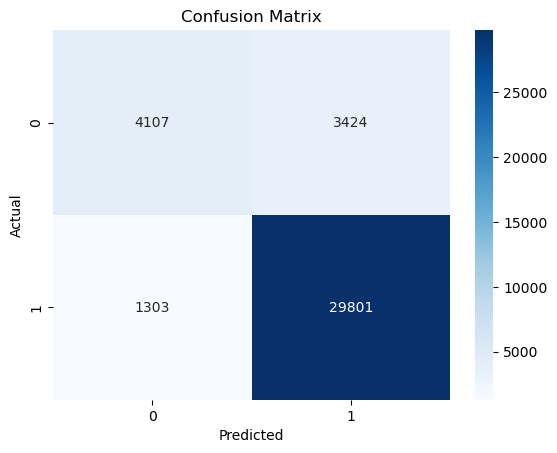

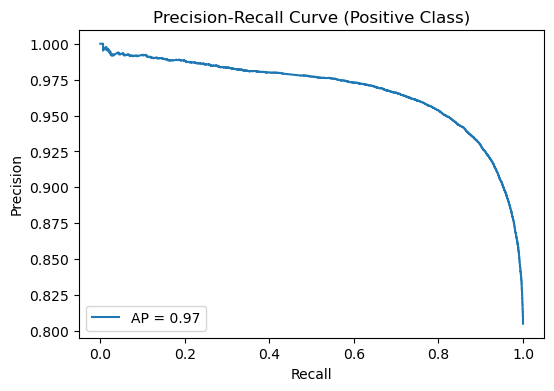

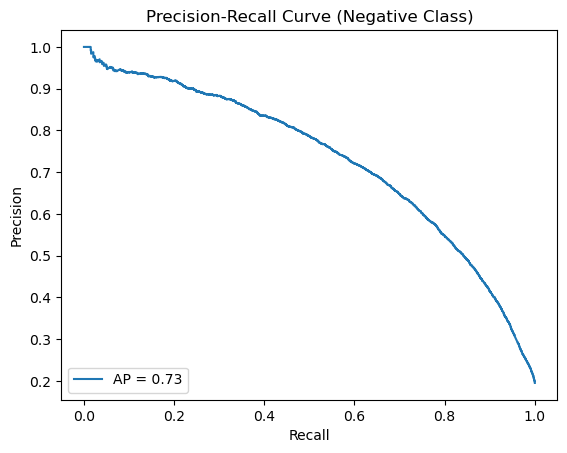

In [126]:
model, mse, acc, cm, report = compute_linear_regression(tfidf_matrix, labels, plot_confusion_matrix=True, plot_pr_curve=True)

/var/folders/0v/d71lr3kj1vg5dwwpxm3hxpk40000gn/T/ipykernel_13492/858275190.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_combined, palette='coolwarm')


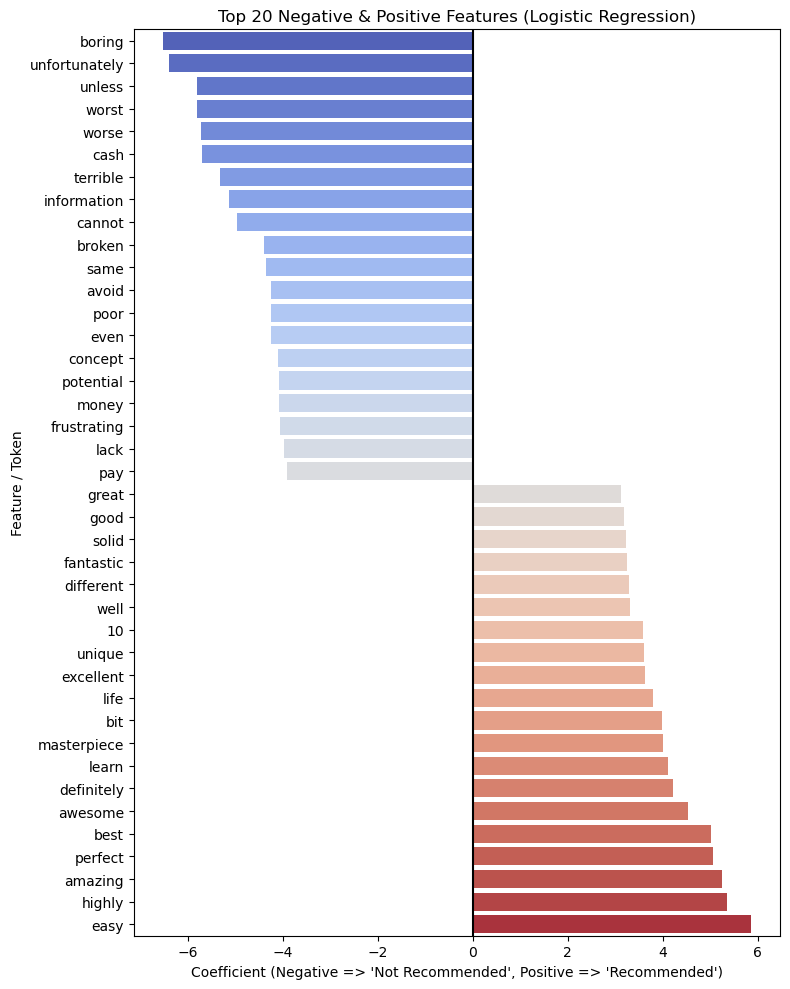

In [132]:
# more visualizations, after training the model:

coefficients = model.coef_[0]  

# Build dataframe
feature_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by ascending coefficient
feature_coef_df = feature_coef_df.sort_values('coefficient', ascending=True)

# Separate negative and positive
top_n = 20
top_negative = feature_coef_df.head(top_n)      # smallest (most negative)
top_positive = feature_coef_df.tail(top_n)      # largest (most positive)

# Combine
top_combined = pd.concat([top_negative, top_positive])

plt.figure(figsize=(8,10))
sns.barplot(x='coefficient', y='feature', data=top_combined, palette='coolwarm')
plt.axvline(0, color='black')
plt.title(f"Top {top_n} Negative & Positive Features (Logistic Regression)")
plt.xlabel("Coefficient (Negative => 'Not Recommended', Positive => 'Recommended')")
plt.ylabel("Feature / Token")
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB



from xgboost import XGBClassifier

In [24]:
def evaluate_naive_bayes(X, y, test_size=0.2):
    """
    Splits the dataset, trains a Naive Bayes classifier (MultinomialNB),
    and evaluates performance.

    Parameters:
    - X: Feature matrix (may not allow LSA features because negative values).
    - y: Ground truth labels.
    - test_size: Fraction of data to use for testing.

    Returns:
    - accuracy: Accuracy score on the test set.
    - nb_model: The trained Naive Bayes model.
    """
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # 2. Instantiate Model
    nb_model = MultinomialNB()
    #nb_model = GaussianNB()        # uncomment for lsa tfidf

    # 3. Train
    nb_model.fit(X_train, y_train)

    # 4. Predict
    y_pred = nb_model.predict(X_test)

    # 5. Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print("Naive Bayes Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    
    # 6. Get predicted probabilities for both classes:
    y_proba = nb_model.predict_proba(X_test)

    # Extract probabilities for the positive class (class=1)
    y_proba_pos = y_proba[:, 1]

    # ------ Precision-Recall for the POSITIVE class ------
    precision_pos, recall_pos, thresholds_pos = precision_recall_curve(
        y_test,            # True labels
        y_proba_pos,       # Probability for label=1
        pos_label=1        
    )
    ap_pos = average_precision_score(y_test, y_proba_pos, pos_label=1)

    # ------ Precision-Recall for the NEGATIVE class ------
    # Extract probabilities for the negative class (class=0)
    y_proba_neg = y_proba[:, 0]

    precision_neg, recall_neg, thresholds_neg = precision_recall_curve(
        y_test,            # True labels
        y_proba_neg,       # Probability for label=0
        pos_label=0        
    )
    
    ap_neg = average_precision_score(y_test, y_proba_neg, pos_label=0)

    # 7. Plot both curves on the same figure
    plt.figure(figsize=(6,4))
    plt.plot(recall_pos, precision_pos, label=f"Positive class (AP={ap_pos:.2f})")
    plt.plot(recall_neg, precision_neg, label=f"Negative class (AP={ap_neg:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Positive and Negative Classes)')
    plt.legend(loc='best')
    plt.show()


    return accuracy, nb_model

TF-IDF NB:
Naive Bayes Accuracy: 0.8114404037789569
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.03      0.06      7489
           1       0.81      1.00      0.90     31146

    accuracy                           0.81     38635
   macro avg       0.88      0.51      0.48     38635
weighted avg       0.84      0.81      0.73     38635



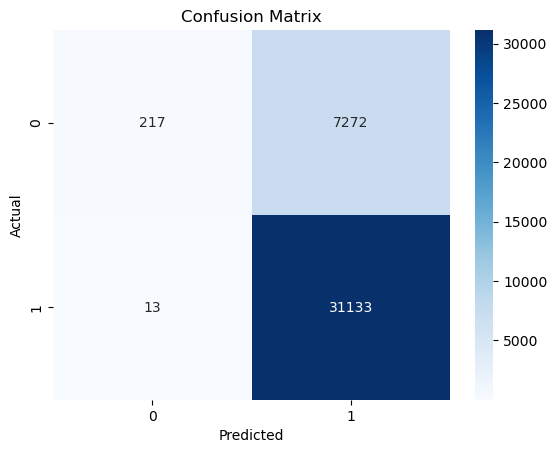

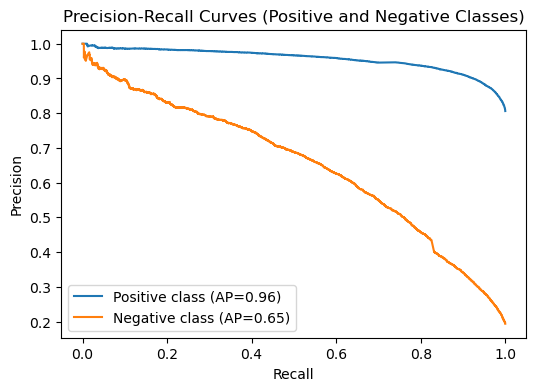

TF-IDF NB with VADER:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Naive Bayes Accuracy: 0.8379448686424227
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.20      0.32      7528
           1       0.84      0.99      0.91     31107

    accuracy                           0.84     38635
   macro avg       0.85      0.60      0.62     38635
weighted avg       0.84      0.84      0.79     38635



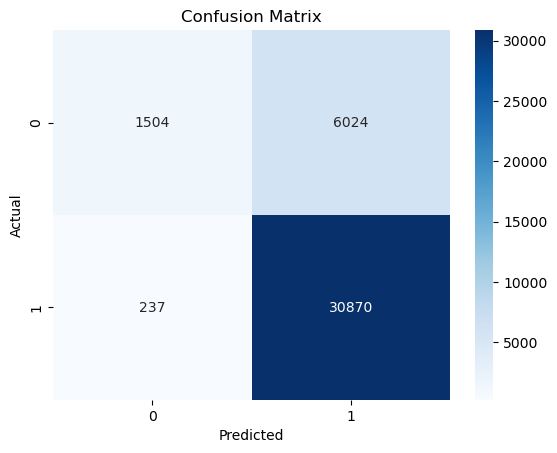

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


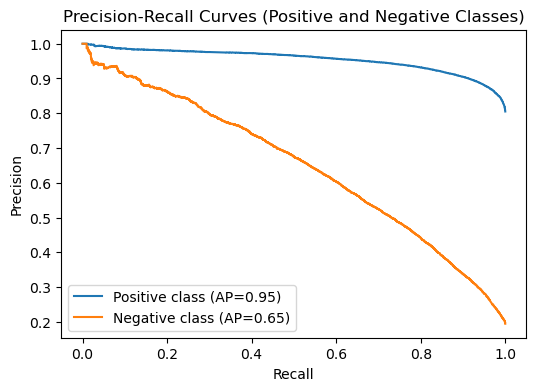

BoW NB: 
Naive Bayes Accuracy: 0.844105086061861
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.66      0.62      7506
           1       0.91      0.89      0.90     31129

    accuracy                           0.84     38635
   macro avg       0.75      0.77      0.76     38635
weighted avg       0.85      0.84      0.85     38635



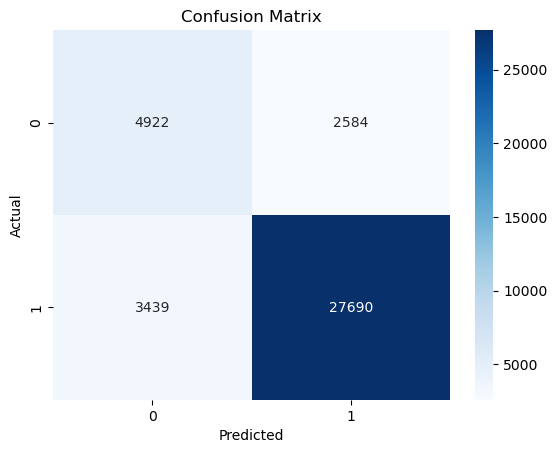

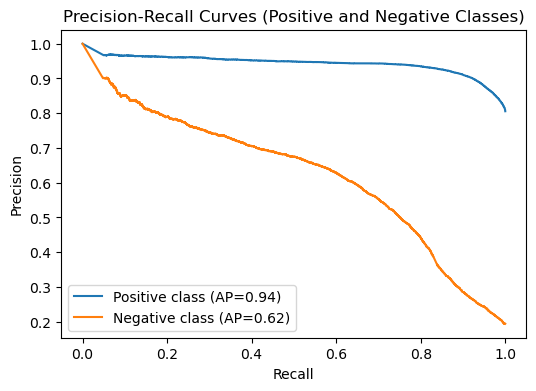

BoW NB with VADER: 


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Naive Bayes Accuracy: 0.8411802769509512
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58      7576
           1       0.90      0.91      0.90     31059

    accuracy                           0.84     38635
   macro avg       0.75      0.74      0.74     38635
weighted avg       0.84      0.84      0.84     38635



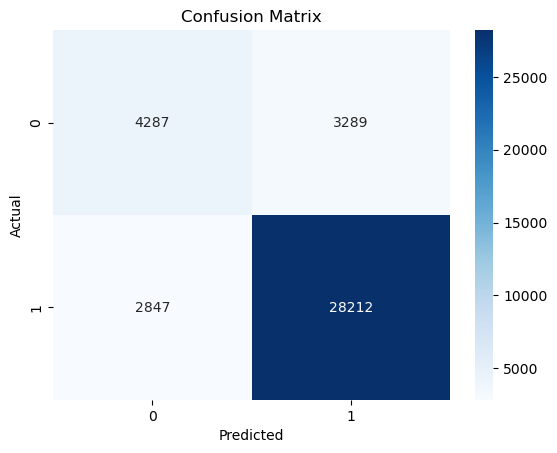

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


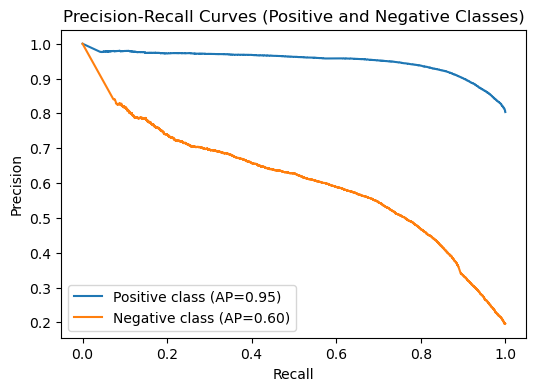

In [25]:
# Run everything

y = create_labels(df)

bow_matrix = compute_bow(documents, max_features)
X_tfidf, feature_names = compute_tfidf(documents, max_features)
X_lsa = apply_lsa(X_tfidf, 100)
vader_scores = compute_vader_sentiment_scores(documents) #create the scores

X_tfidf = pd.DataFrame(X_tfidf.toarray())
bow_matrix = pd.DataFrame(bow_matrix.toarray())

vader_scores_shifted = vader_scores.copy()
for col in ['pos', 'neu', 'neg', 'compound']:
    vader_scores_shifted[col] += 1

# Make sparse
vader_scores_sparse = vader_scores_shifted.astype(pd.SparseDtype("float", fill_value=0))

#vader_scores = vader_scores.astype(pd.SparseDtype("float", fill_value=0))
X_tfidf_vader = pd.concat([X_tfidf, vader_scores_sparse], axis=1)
X_tfidf_vader.columns = X_tfidf_vader.columns.astype(str)
#X_tfidf_vader = hstack([X_tfidf, vader_scores.sparse.to_coo()])
bow_matrix_vader = pd.concat([bow_matrix, vader_scores_sparse], axis=1)
bow_matrix_vader.columns = bow_matrix_vader.columns.astype(str)
#bow_matrix_vader = hstack([X_tfidf, vader_scores.sparse.to_coo()])

#NB for tf-idf
print("TF-IDF NB:")
acc_nb, model_nb = evaluate_naive_bayes(X_tfidf, y)

print("TF-IDF NB with VADER:")
acc_nb, model_nb = evaluate_naive_bayes(X_tfidf_vader, y)

# NB for BoW
print("BoW NB: ")
acc_nb_bow, model_nb_bow = evaluate_naive_bayes(bow_matrix, y)

print("BoW NB with VADER: ")
acc_nb_bow, model_nb_bow = evaluate_naive_bayes(bow_matrix_vader, y)

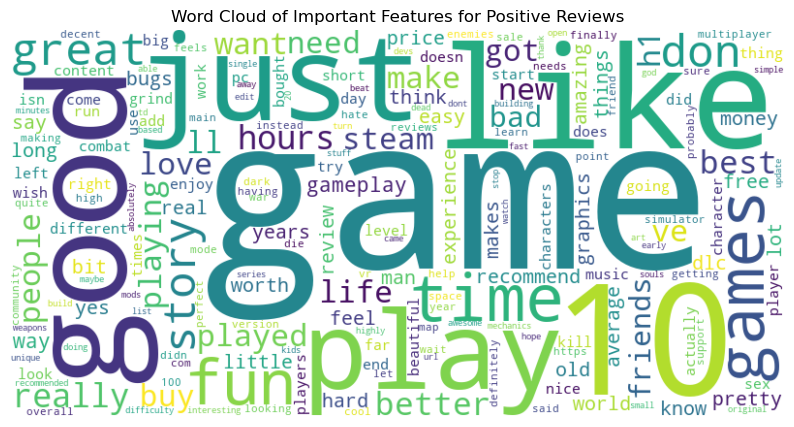

In [79]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Get the log probabilities of features for each class
# Assuming model_nb is a trained MultinomialNB or similar Naive Bayes model
class_log_probs = model_nb.feature_log_prob_

# Focus on one class (e.g., class 1)
class_index = 1  # Change to 0 or 1 depending on the class you want to visualize
feature_importances = np.exp(class_log_probs[class_index])  # Convert log probabilities to probabilities

# Create a dictionary mapping words to their importance
word_importance = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

# Filter out stop words
filtered_word_importance = {
    word: importance
    for word, importance in word_importance.items()
    if word not in ENGLISH_STOP_WORDS
}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_word_importance)


# title based on class index

title = "Word Cloud of Important Features for Positive Reviews" if class_index == 1 else "Word Cloud of Important Features for Negative Reviews"


# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(title)
plt.show()

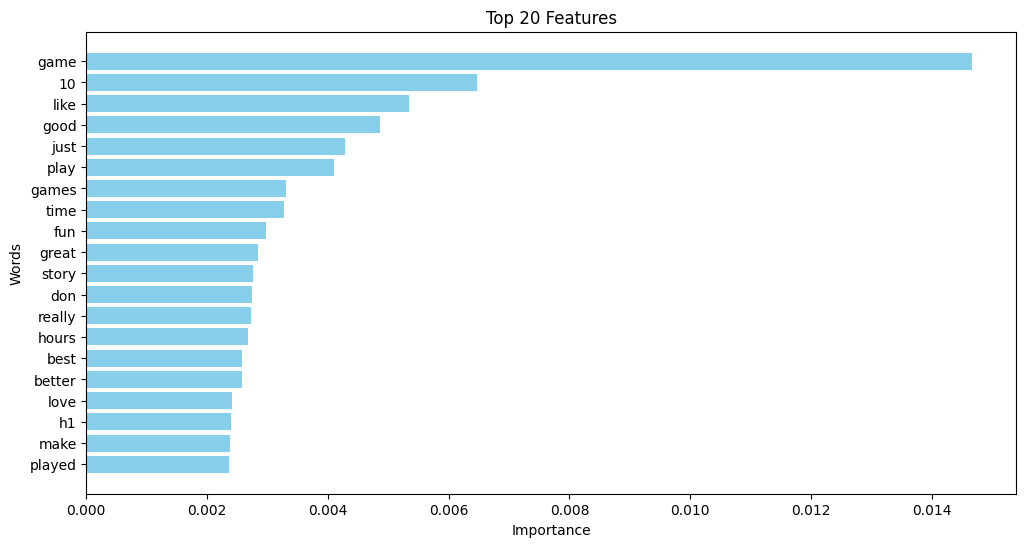

In [210]:

# Convert the adjective importance dictionary to a DataFrame
adjective_df = pd.DataFrame(list(filtered_word_importance.items()), columns=['Word', 'Importance'])

# Sort by importance and select the top N features
top_n = 20
top_adjectives = adjective_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_adjectives['Word'], top_adjectives['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title(f'Top {top_n} Features')
plt.show()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/lancesinson/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lancesinson/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/lancesinson/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/lancesinson/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/lancesinson/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is a

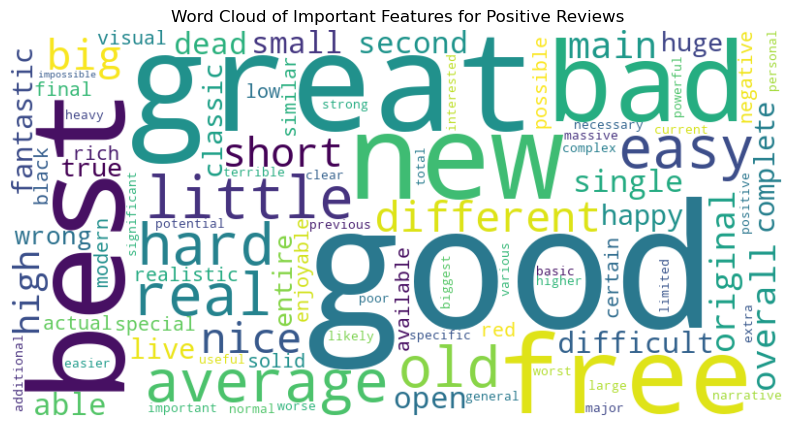

In [81]:

from nltk import pos_tag
from nltk.corpus import wordnet

# Download NLTK resources if not already downloaded
nltk.download('all')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Get the log probabilities of features for each class
# Assuming model_nb is a trained MultinomialNB or similar Naive Bayes model
class_log_probs = model_nb.feature_log_prob_

# Focus on one class (e.g., class 1)

feature_importances = np.exp(class_log_probs[class_index])  # Convert log probabilities to probabilities

# Create a dictionary mapping words to their importance
word_importance = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

# Filter out stop words
filtered_word_importance = {
    word: importance
    for word, importance in word_importance.items()
    if word not in ENGLISH_STOP_WORDS
}

# Filter to include only adjectives
def is_adjective(word):
    pos = pos_tag([word])[0][1]  # Get the part of speech tag
    return pos.startswith('JJ')  # Adjectives in NLTK are tagged as 'JJ', 'JJR', or 'JJS'

adjective_word_importance = {
    word: importance
    for word, importance in filtered_word_importance.items()
    if is_adjective(word)
}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adjective_word_importance)


# title based on class index
title = "Word Cloud of Important Features for Positive Reviews" if class_index == 1 else "Word Cloud of Important Features for Negative Reviews"


# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(title)
plt.show()

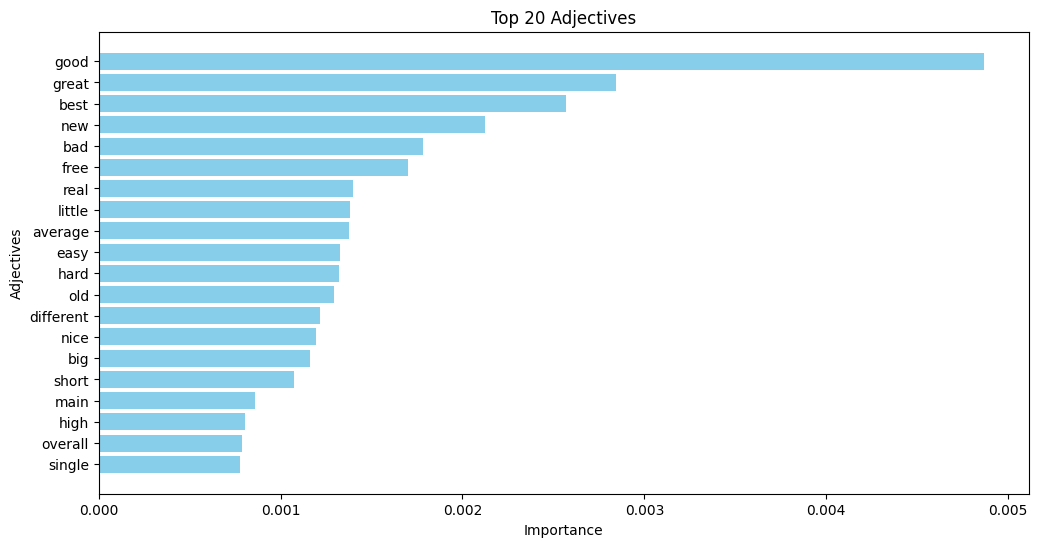

In [212]:


# Convert the adjective importance dictionary to a DataFrame
adjective_df = pd.DataFrame(list(adjective_word_importance.items()), columns=['Word', 'Importance'])

# Sort by importance and select the top N features
top_n = 20
top_adjectives = adjective_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_adjectives['Word'], top_adjectives['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Adjectives')
plt.title(f'Top {top_n} Adjectives')
plt.show()

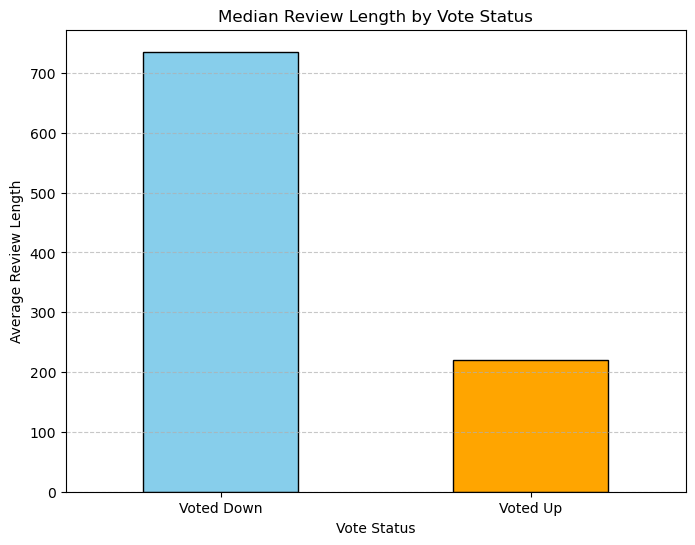

In [83]:
# Load the CSV file
file_path = "cleaned_data.csv"  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Calculate the length of each review
df['review_length'] = df['review'].astype(str).apply(len)

# Group by 'voted_up' and calculate the average review length
avg_review_length = df.groupby('voted_up')['review_length'].median()

# Plot the bar chart
plt.figure(figsize=(8, 6))
avg_review_length.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')

# Update the x-axis labels
plt.title('Median Review Length by Vote Status')
plt.xlabel('Vote Status')
plt.ylabel('Average Review Length')
plt.xticks(ticks=[0, 1], labels=['Voted Down', 'Voted Up'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

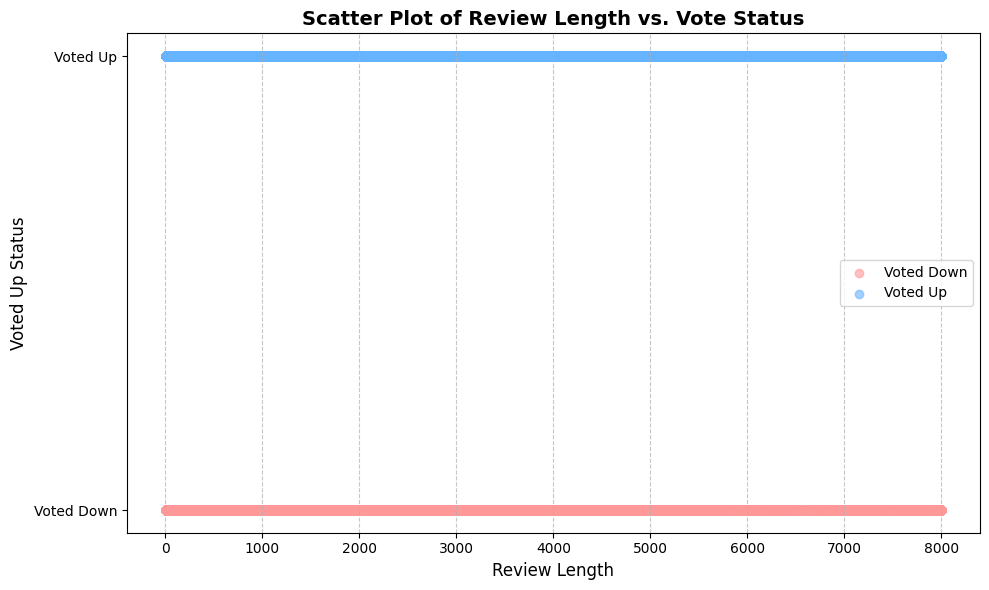

In [214]:


# Calculate the length of each review
df['review_length'] = df['review'].astype(str).apply(len)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    df[df['voted_up'] == 0]['review_length'],  # Review lengths for 'Not Voted Up'
    [0] * len(df[df['voted_up'] == 0]),       # Corresponding y-values (voted_up = 0)
    color='#FF9999', alpha=0.6, label='Voted Down'
)
plt.scatter(
    df[df['voted_up'] == 1]['review_length'],  # Review lengths for 'Voted Up'
    [1] * len(df[df['voted_up'] == 1]),       # Corresponding y-values (voted_up = 1)
    color='#66B3FF', alpha=0.6, label='Voted Up'
)

# Add titles and labels
plt.title('Scatter Plot of Review Length vs. Vote Status', fontsize=14, fontweight='bold')
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Voted Up Status', fontsize=12)
plt.yticks([0, 1], ['Voted Down', 'Voted Up'])  # Custom y-axis labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# t-SNE Visualizations (2D, 3D)

In [215]:
# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=130, perplexity=30)
X_tsne = tsne.fit_transform(lsa_matrix)

# Plot the results
plt.figure(figsize=(10,7))

# Create the scatter plot
scatter2D = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7, s=10)

plt.colorbar(scatter2D, label='Recommended (1) / Not Recommended (0)')
plt.title('t-SNE Visualization of Steam Review Embeddings')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:

# t-SNE with 3 components, fit using LSA-reduced matrix
tsne_3d = TSNE(n_components=3, random_state=130, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(lsa_matrix)

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter3D = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=labels, cmap='coolwarm', alpha=0.7, s=15)

ax.set_title("3D t-SNE Visualization of Steam Reviews")
fig.colorbar(scatter3D, label='Recommended (1) / Not Recommended (0)')

plt.show()


# Top-N Feature Plot

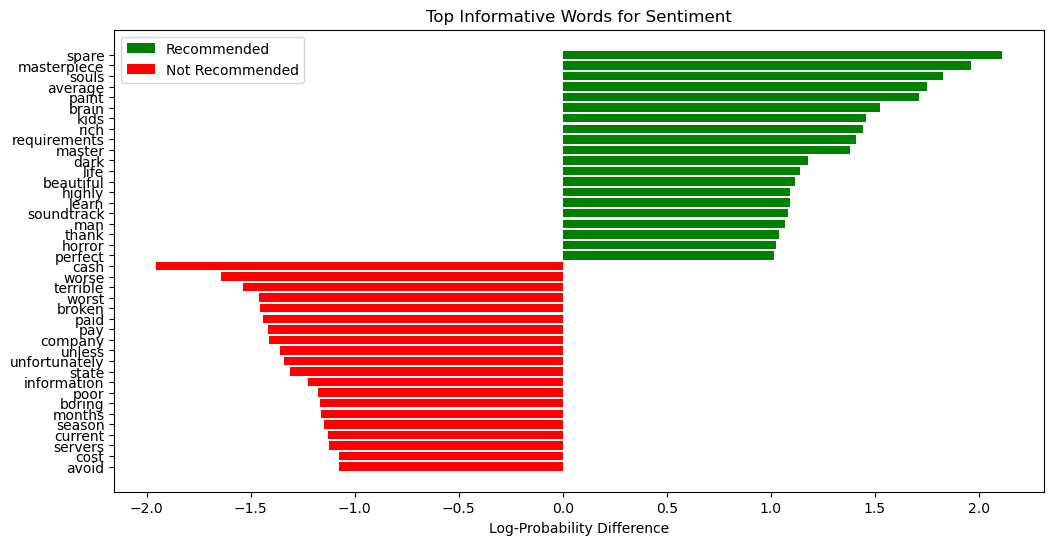

In [73]:
# Get the log probabilities of features
class_log_probs = model_nb.feature_log_prob_

# Get the difference between class 1 and class 0 (Recommended vs Not Recommended)
log_prob_diff = class_log_probs[1] - class_log_probs[0]  # Higher = more likely to be in recommended reviews

# Map words to importance difference and filter out common/junk words
word_importance = {feature_names[i]: log_prob_diff[i] for i in range(len(feature_names))}

custom_stopwords = ENGLISH_STOP_WORDS.union({'game', 'games', 'player', 'players'})
filtered_word_importance = {word: importance for word, importance in word_importance.items() if word.lower() not in custom_stopwords and word.isalpha() and len(word) > 2}

# Create DataFrame of word importances
importance_df = pd.DataFrame(list(filtered_word_importance.items()), columns=['Word', 'Importance'])

# Get the Top N positive (recommended) and Top N negative (not recommended) words
top_n = 20
top_positive = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
top_negative = importance_df.sort_values(by='Importance', ascending=True).head(top_n)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_positive['Word'], top_positive['Importance'], color='green', label='Recommended')
plt.barh(top_negative['Word'], top_negative['Importance'], color='red', label='Not Recommended')
plt.xlabel('Log-Probability Difference')
plt.title('Top Informative Words for Sentiment')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# BoW Top-N Feature Plot

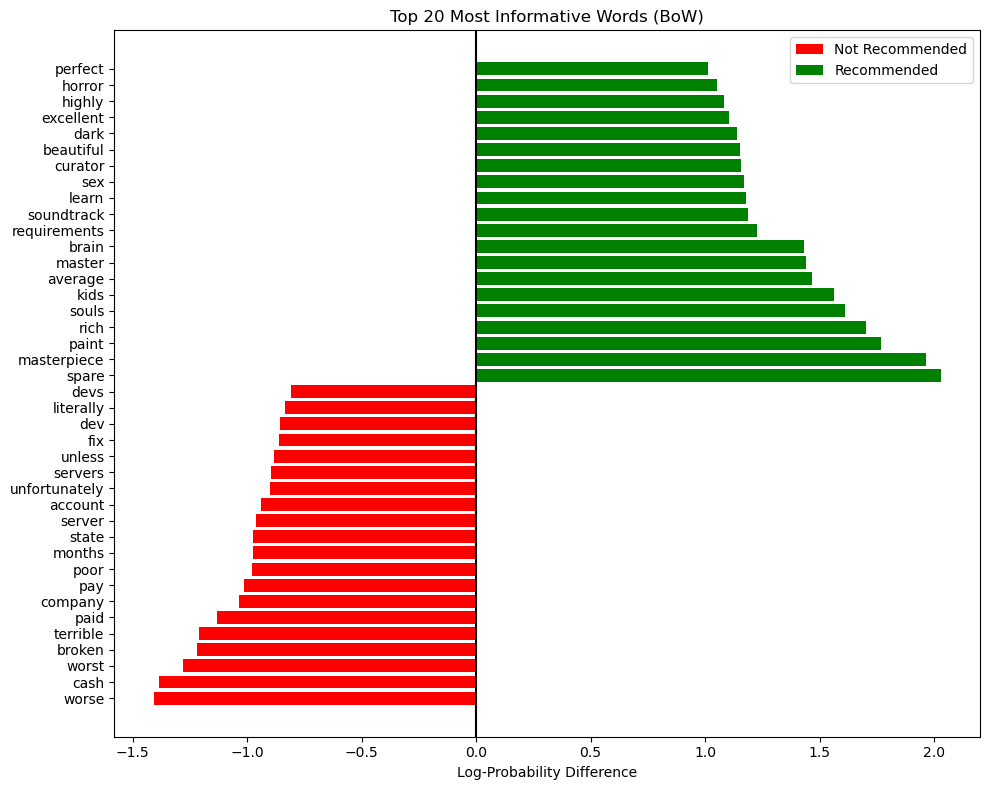

In [75]:
# Get feature names from BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=max_features)
bow_vectorizer.fit(documents)
bow_feature_names = bow_vectorizer.get_feature_names_out()

# Get feature importance (difference between class log probs)
class_log_probs_bow = model_nb_bow.feature_log_prob_
log_prob_diff_bow = class_log_probs_bow[1] - class_log_probs_bow[0]

# Build dataframe
word_importance_bow = {bow_feature_names[i]: log_prob_diff_bow[i] for i in range(len(bow_feature_names))}

# Filter out common stopwords
filtered_word_importance_bow = {word: importance for word, importance in word_importance_bow.items() if word.lower() not in custom_stopwords and word.isalpha() and len(word) > 2}

importance_df_bow = pd.DataFrame(
    list(filtered_word_importance_bow.items()), columns=['Word', 'Importance']
)

# Plot Top-N Features
top_n = 20
top_positive_bow = importance_df_bow.sort_values(by='Importance', ascending=False).head(top_n)
top_negative_bow = importance_df_bow.sort_values(by='Importance', ascending=True).head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_negative_bow['Word'], top_negative_bow['Importance'], color='red', label='Not Recommended')
plt.barh(top_positive_bow['Word'], top_positive_bow['Importance'], color='green', label='Recommended')
plt.axvline(0, color='black')
plt.xlabel('Log-Probability Difference')
plt.title(f'Top {top_n} Most Informative Words (BoW)')
plt.legend()
plt.tight_layout()
plt.show()

# BoW WordCloud

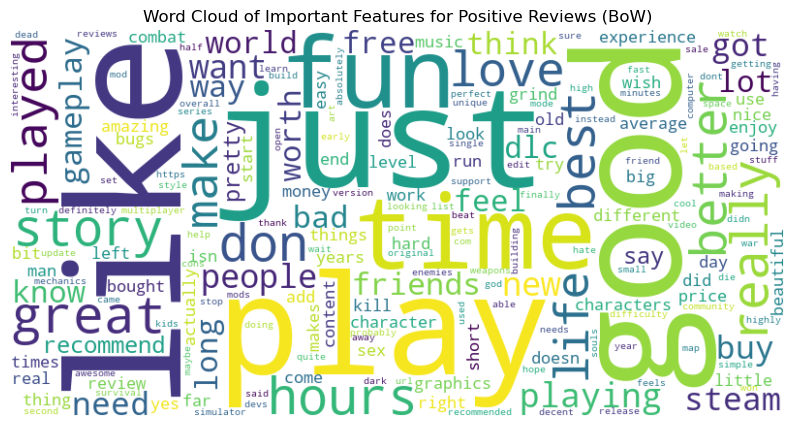

In [77]:
# Get log probs of the features for each class
class_log_probs_bow = model_nb_bow.feature_log_prob_

# Focus on a single class
class_index = 1  # 1 = recommended, 0 = not recommended
feature_importances = np.exp(class_log_probs[class_index])  # convert log-probs to probs

# Create word importance dictionary
word_importance = {bow_feature_names[i]: feature_importances[i] for i in range(len(bow_feature_names))}

# Filter out common stopwords + junk
filtered_word_importance = {word: importance for word, importance in word_importance.items() if word.lower() not in custom_stopwords and word.isalpha() and len(word) > 2}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_word_importance)

# Plot
title = "Word Cloud of Important Features for Positive Reviews (BoW)" if class_index == 1 else "Word Cloud of Important Features for Negative Reviews"

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(title)
plt.show()
